We create truth subsets for each alternative allele frequency (AAF) in each mix of the 4 CEPH/Utah grandparental genomes.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.dpi'] = 150
#matplotlib.rcParams['figure.figsize'] = [7, 5]
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joint_gt_ceph as jgc
import truth_sets_aaf as tsa
import downsize_truthset as dsts
import somaticvar_models as svm

The operations below create truth subsets for each frequency (aaf), variant type (snp or indel) and sample (mix1, mix2, mix3) and also calculate the size of each subset (nvariants)

In [19]:
def tsaaf(mix, vartype, region):
    bdir = '/home/attila/projects/bsm/results/2019-03-18-truth-sets/'
    return(tsa.make_ts_aaf(mix=mix, vartype=vartype, region=region, tsdir=bdir + os.sep + region + os.sep + vartype + '/truthset'))

nvariants = pd.concat([tsaaf(mix=m, vartype=v, region=r) for r in ['chr22', 'autosomes'] for v in ['snp', 'indel'] for m in ['mix1', 'mix2', 'mix3']])

In [21]:
nvariants.head()

,aaf,nvariants,region,sample,vartype
0,2,11351,chr22,mix1,snp
1,4,15342,chr22,mix1,snp
2,6,3641,chr22,mix1,snp
3,8,18832,chr22,mix1,snp
4,10,6239,chr22,mix1,snp


The number of variants in each subset shows the following dependency on frequency (aaf), sample and variant type:

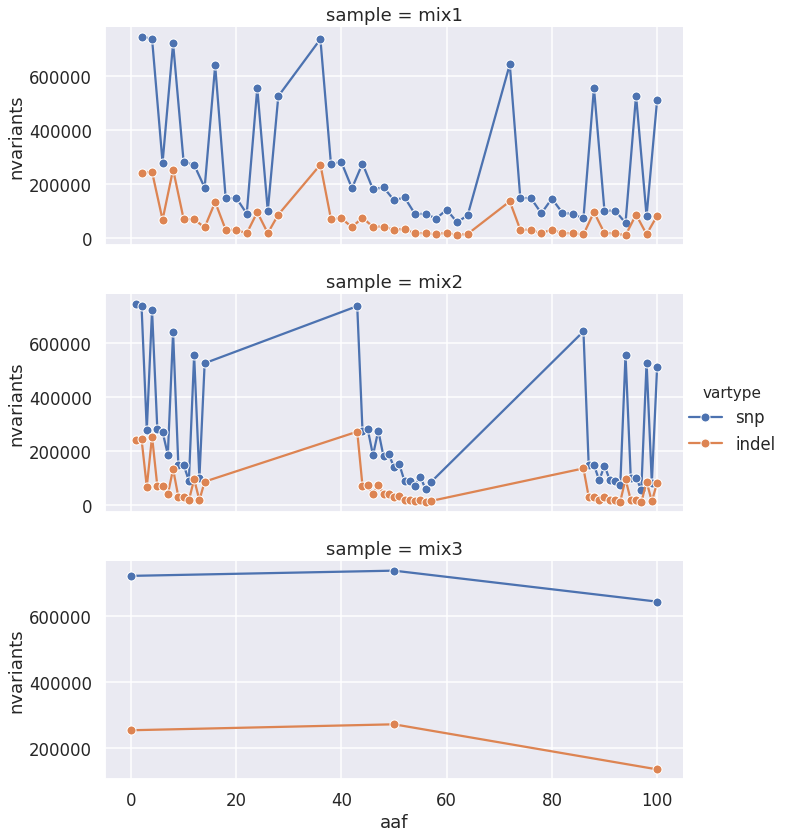

In [27]:
sns.set()
sns.set_context('talk')
def nvar_aaf_plot(region='autosomes'):
    fg = sns.FacetGrid(data=nvariants.loc[nvariants['region'] == region, :], row='sample', hue='vartype', sharey=False, aspect=2.5, height=4)
    fg = fg.map(plt.plot, 'aaf', 'nvariants', marker='o', markeredgecolor='white', linestyle='solid')
    fg = fg.add_legend()
    return(fg)

nvar_aaf_plot('autosomes')

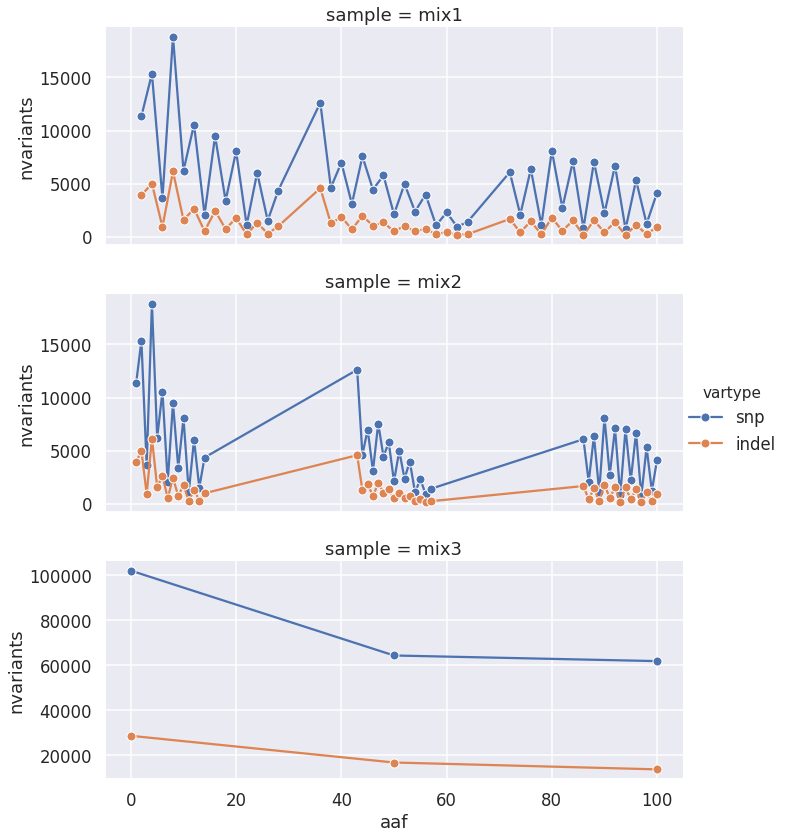

In [28]:
nvar_aaf_plot('chr22')

To calculate the total number of variants by summing the number of variants over all frequencies

In [34]:
def do_sum(mix, vartype, region):
    a = nvariants['sample'] == mix
    b = nvariants['vartype'] == vartype
    c = nvariants['region'] == region
    #nvars = nvariants.loc[[a & b & c], 'nvariants']
    nvars = nvariants.loc[[y[0] and y[1] and y[2] for y in zip(a, b, c)], 'nvariants']
    return(sum(nvars))

{r: {v: {m: do_sum(m, v, r) for m in ['mix1', 'mix2', 'mix3']} for v in ['snp', 'indel']} for r in ['chr22', 'autosomes']}

{'autosomes': {'indel': {'mix1': 2810148, 'mix2': 2810148, 'mix3': 662759},
  'snp': {'mix1': 11733861, 'mix2': 11733861, 'mix3': 2103781}},
 'chr22': {'indel': {'mix1': 59056, 'mix2': 59056, 'mix3': 59056},
  'snp': {'mix1': 228141, 'mix2': 228141, 'mix3': 228141}}}

## Downsampling truth subsets

We don't know the number of somatic mutations in neurons.  More precisely we don't know the average number nor how it varies across cells.  Therefore we neither know how the relationship between the number of variants and alternative allele frequency (AAF) in our multinuclear/multicellular samples for bulk sequencing.

This forces us to be hypothetical, simplifying, and allow a few distinct models that describe both the total number of somatic variants as well as dependence on AAF.

I use the following simple principles
1. the total number of somatic variants is some small fraction of that of germline variants both for SNPs/SNVs and indels
1. the number of somatic variants is a linear function of AAF that
    * is either constant or decreasing
    * takes values on the domain $X$ such that $\mathrm{AAF} \in X \subset (0, 1) \setminus \{0.5\}$

### Remarks

If the function is decreasing it means that we believe that most somatic mutations arose relatively late so that they didn't have the opportunity to spread out to larger mosaic areas.

Excluding $\{0.5\}$ means that we use the simplifying assumption that if a variant has AAF it means it can only be a germline variant for which the individual is heterozygous.  Thus any call of *somatic* variants at $\mathrm{AAF}=0.5$ will be considered false even if we allow some somatic variants at, say, $\mathrm{AAF}=0.52$.

## Modeling the number of somatic variants

We will consider two aspects for building models
1. the total number of somatic variants
1. the number of somatic variants as a function of AAF

### The total number of somatic variants

Let $Y$ denote the total number of somatic variants.  We will speculatively set $Y$ as a fixed fraction of the number of germline variants.

To deal with germline variants we make use of the length of all autosomes and of chr22, which are obtained from `/big/data/refgenome/GRCh37/hs37d5/hs37d5.fa.fai`.

In [43]:
hs37d5_len = {'autosomes': 2929051733, 'chr22': 51304566}

The number for germline SNPs in an "average" human is 4.5 million based on [common knowledge](https://ghr.nlm.nih.gov/primer/genomicresearch/snp); my recent analysis shows that this is consistent with the number of germline SNPs in NA12889.  The same analysis gave more that 0.7 million indels for NA12889.

In [44]:
germ_vars = {'snp': 4e6, 'indel': 0.8e6}
germ_vars = {k: [int(germ_vars[k] * hs37d5_len['chr22'] / hs37d5_len['autosomes']), int(germ_vars[k])] for k in germ_vars.keys()}
germ_vars = pd.DataFrame(germ_vars, index=hs37d5_len.keys())
germ_vars

,indel,snp
chr22,14012,70063
autosomes,800000,4000000


If $G$ is the number of somatic variants (SNPs or indels in chr22 or all autosomes) then let
$$
\begin{eqnarray}
Y^{(1)} &=& 10^{-2} G \\
Y^{(2)} &=& 10^{-3} G \\
Y^{(3)} &=& 10^{-4} G
\end{eqnarray}
$$


### The number of somatic variants as a function of AAF

Let total number of somatic variants $Y\equiv Y^{(k)}$ for some fixed $k\in \{1, 2, 3\}$.  Then $Y = \sum_{i=1}^{n} y_i$, where $\{(y_i, x_i)\}_{i=1,...,n}$ is the set of $n$ point pairs $(y_i, x_i)$ of somatic variant count $y_i$ and the corresponding alternative allele frequency $x_i$.

$\{x_i\}_{i=1,...,n}$ are already given.  $Y$ will be given below.  The goal is to obtain $\{y_i\}_{i=1,...,n}$ under some simple mathematical model.

## Models


### At a given total number of somatic variants 

For simplicity let's build a set $\{M_j^{(k)}\}_{j=1,2,3}$ of three models first at some fixed $k$ and use the simple notation $M_j\equiv M_j^{(k)}$ as well as $Y\equiv Y^{(k)}$.  Later we will extend this initial set of models to all possible $k\in \{1, 2, 3\}$.

We'll consider three models: $M_j,\;j=1,2,3$.  Below is the general form of $M_j$

$$
\begin{equation}
y_i = a_j + b_j x_i
\end{equation}
$$

Consequently
\begin{equation}
Y = a_j n_j + b \sum_{i=1}^{n_j} x_i
\end{equation}

What distinguishes the models is the relationship between $a_j$ and $b_j$ for each $j$:

$$
\begin{eqnarray}
b_j &=& - \frac{a_j}{x_\mathrm{max}^{(j)}}, \; j=1,2 \\
b_3 &=& 0
\end{eqnarray}
$$

Thus in $M_1$ and $M_2$ the slope of the linear function is negative while in $M_3$ it is zero.  Distinguishing between $M_1$ and $M_2$ is $x_\mathrm{max}^{(j)}$, the AAF at which the variant count becomes zero:

$$
\begin{eqnarray}
x_\mathrm{max}^{(1)} &=& 50 \\
x_\mathrm{max}^{(2)} &=& 100 \\
\end{eqnarray}
$$

Roughly speaking this means that
1. in $M_1$ the number of variants decreases steeply from $y=a_1$ at AAF of $0$ to $y=0$ at AAF of $50$
2. in $M_2$ the decrease is less steep: from $y=a_2 < a_1$ at AAF of $0$ to $y=0$ at AAF of $100$
3. in $M_3$ the number of variants is constant across $x_1,...,x_{n_3}$

Note that $n_1 = n_3 > n_2$.

The specifications above allow us to express $a_j$ with the known quantities as well as $x_\mathrm{max}^{(j)}$

$$
\begin{eqnarray}
a_j &=& Y \left( n_j - \frac{1}{x_\mathrm{max}^{(j)}} \sum_{i=1}^{n_j} x_i \right)^{-1}, \; j=1,2 \\
a_3 &=& y_1 =...= y_{n_3} = Y n_3^{-1}
\end{eqnarray}
$$

### Extensions

Extension of the three models described above to several total number of somatic variants is straight forward, yielding $3\times 3 = 9$ models $\{M_j^{(k)}:\; j=1,2,3;\; k=1,2,3\}$.

A further extension is to distinguish between SNPs and indels as well as between all autosomes and chr22, which gives $2\times 2 \times 9 = 36$ models.

In [55]:
xset = nvariants.loc[(nvariants['region'] == 'autosomes') & (nvariants['sample'] == 'mix1') & (nvariants['vartype'] == 'snp'), 'aaf']
svm.get_yset(Y=germ_vars.at['chr22', 'snp'], xset=xset, x_max=50, only_params=True)

{'a': 6416.025641025641, 'b': -128.32051282051282}

In [63]:
def foo(mix, vartype, region, x_max):
    y = svm.get_yset(Y=germ_vars.at[region, vartype], xset=xset, x_max=x_max, only_params=False)
    df = pd.DataFrame({'y': y, 'x': xset, 'x_max': x_max, 'mix': mix, 'vartype': vartype, 'region': region})
    return(df)
#y = svm.get_yset(Y=germ_vars.at['chr22', 'snp'], xset=xset, x_max=50, only_params=False)
foo(mix='mix1', vartype='snp', region='chr22', x_max=50)

,mix,region,vartype,x,x_max,y
0,mix1,chr22,snp,2,50,6159.384615
1,mix1,chr22,snp,4,50,5902.743590
2,mix1,chr22,snp,6,50,5646.102564
3,mix1,chr22,snp,8,50,5389.461538
4,mix1,chr22,snp,10,50,5132.820513
5,mix1,chr22,snp,12,50,4876.179487
6,mix1,chr22,snp,14,50,4619.538462
7,mix1,chr22,snp,16,50,4362.897436
8,mix1,chr22,snp,18,50,4106.256410
9,mix1,chr22,snp,20,50,3849.615385
